In [1]:
import scipy
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift, estimate_bandwidth

import pandas as pd

from scipy import stats
from scipy.stats import beta
from math import sin
from random import randint

import matplotlib.pyplot as plt
import itertools as it

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
init_notebook_mode(connected=True)

import collections

def recursively_default_dict():
        return collections.defaultdict(recursively_default_dict)

from matplotlib.collections import BrokenBarHCollection
import re

from structure_tools.Modules_tools import return_fsts

PCA_color_ref= ['darkseagreen','crimson', 'darkorange', 'darkblue', 'darkcyan',
            'darkgoldenrod', 'darkgray', 'darkgrey', 'darkgreen',
            'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange',
            'darkorchid', 'darkred', 'darksalmon', 'darkseagreen',
            'darkslateblue', 'darkslategray', 'darkslategrey',
            'darkturquoise', 'darkviolet', 'deeppink']

### .vcf analysis

Jupyter notebook for the local analysis of genetic data stored in `.vcf` format.

Perform analysis of structure across data set, followed by a more detailed study of variation across local genomic windows.

This particular notebook constitutes a case study of rice (*Oryza sativa*) genetic variation across a single chromosome. Data was extracted from the 3K RG data set (Mansueto *et al*. 2017) and filtered for missing data (< 0.001 % per SNP). One accession was removed for excess missing data. A subset of 15 thousand loci was then sampled randomly from chromosome 8 and converted to .vcf format (see [Upstream pre-process](https://github.com/SantosJGND/Galaxy_KDE_classifier/tree/master/Upstream_process)). 

### Index:

**A. Input**

>i. Read vcf data and passport information of accessions within. 

>ii. Sample loci and accessions for a smaller data set. 

**B. Global structure analysis.**

>i. Perform PCA and Mean Shift.

>ii. Visualize structure. Decide wheather to use Mean Shift results or input classes going further.

**C. Window sub-divide.**

>i. Chose window size (in SNPs) and distance between windows. Windows overlap if Steps < Window_length.

**D. Local cluster identification**

>i. Perform mean shift clustering across windows.

**E. Supervised classification.**

>i. Chose reference groups, perform kernel density estimation across windows, extract p-values.

>ii. Study classification patterns across windows. Alows intermediate and outlier classes.

**F. Curation**

>i. provide region and classification. Estimate label / cluster similarity across range provided.

>ii. Label clusters based on supervised classification accuracy. Verification plot.

>iii. Propose label modification and plot new classification output.




### Reference

- Mansueto, et al. Rice SNP-seek database update: new SNPs, indels, and queries.Nucl. Acids Res.(2017) 45 (D1): D1075-D1081. doi: 10.1093/nar/gkw1135 This paper describes new features and datasets added to SNP-Seek in 2015-2017 as well as software and database updates.

### A. Input

#### i. Read vcf, read passport data

In [3]:
from structure_tools.vcf_geno_tools import read_geno_nanum

filename= 'Filtered_Chr8_miss0.01.vcf'

row_info= 6
header_info= 9
phased= False

genotype, summary, Names= read_geno_nanum(filename, row_info= row_info, header_info= header_info,phased= phased)

print('Number of markers: {}'.format(genotype.shape[1]))
print('Number of individuals: {}'.format(genotype.shape[0]))


{'fileformat': 'VCFv4.2', 'fileDate': '20190322', 'source': 'PLINKv1.90', 'contig': '<ID8,length28428625>', 'INFO': '<IDPR,Number0,TypeFlag,Description"Provisional reference allele, may not be based on real reference genome">', 'FORMAT': '<IDGT,Number1,TypeString,Description"Genotype">'}
Number of markers: 15000
Number of individuals: 3023


In [4]:
## read passport information

Input_file= '3K_info.txt'

RG_info= pd.read_csv('3K_info.txt',sep= '\t')

RG_info.head()

,IRIS_ID,NAME,Variety_Name_verif,COUNTRY,REGION,K9_cluster,Initial_subpop
0,B001,HEIBIAO,Heibiao,China,As6,GJ-tmp,temp
1,B002,SANSUIJIN,Sansuijin,China,As6,GJ-tmp,temp
2,B003,ZAOSHENGBAI,Zaoshengbai_,China,As6,GJ-adm,japx
3,B004,QIUGUANGTENGXI_104,Qiuguangtengxi_104_,Japan,As7,GJ-tmp,temp
4,B005,WANSHI,Wanshi,Japan,As7,GJ-tmp,temp


In [5]:
## Process Names vcf names.
## Instance specific processing due to ID copy in VCF file.

for x in range(len(Names)):
    ind= Names[x]
    newid= ind.split('_')
    if len(newid) > 2:
        newid= '_'.join(newid[:2])
    else:
        newid= newid[0]
    
    Names[x]= newid



#### ii. Subset accessions and SNPs

Chose *Sn* and *Sm* for individual and marker number. Indexes will be selected randomly. 

*This step will allow for an input file for selection in the near future*

In [7]:
from structure_tools.vcf_geno_tools import geno_subset_random

Sn= 650
Sm= 13000

ID_col= 'IRIS_ID'
subset_col= 'Initial_subpop'

code= {
    'ind1A':0,
    'ind1B':0,
    'ind2':0,
    'ind3':0,
    'aus':1,
    'temp':2,
    'trop':2,
    'subtrop':2,
    'aro': 3,
    'admx': 4
}


others= 'admx'

gen_sample, subsummary, code_vec, code_lib, Nsample, Msample= geno_subset_random(genotype,
                                                                                 summary,
                                                                                 RG_info,
                                                                                 ID_col,
                                                                                 subset_col,
                                                                                 Names,
                                                                                 code= code,
                                                                                 others= others,
                                                                                 Sn= Sn, Sm= Sm)

color_groups= ['red','yellow','blue','green','purple','black','silver','silver','red3','deepskyeblue','navy','chartreuse','darkorchid3','goldenrod2']



gen_sample shape: 650, 13000


### B. Global variation

#### i. PCA

Perform PCA across data set.

Perform Mean shift clustering to attempt to extract genetically coherent groups of accessions.

These can later be used for supervised analysis.

In [8]:
## Perform PCA
n_comp= 5
pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

feats= pca.fit_transform(gen_sample)

In [9]:
## perform MeanShift clustering.
bandwidth = estimate_bandwidth(feats, quantile=0.15)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=True, min_bin_freq=15)
ms.fit(feats)
labels1 = ms.labels_
label_select = {y:[x for x in range(len(labels1)) if labels1[x] == y] for y in sorted(list(set(labels1)))}


#### ii. Structure and classification

Analyse structure in data set as conveyed by PCA. 

In [10]:
###
from structure_tools.Tutorial_subplots import plot_global_classes


plot_global_classes(feats,
                    code_lib,
                    label_select,
                    color_groups,
                    PCA_color_ref,
                    title_I= 'IRRI class',
                    title_II= 'Mean_shift',height= 900, width= 950)


This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]
[ (2,1) x3,y3 ]  [ (2,2) x4,y4 ]



### iii. Select factor 

The analyses below will be informed by the distributions of groups of accessions. Chose wheather to analyse using the clustering performed here, or that provided in the input passport file. 

*Come back to this step to repeat analyses with a different set of labels.*

In [11]:
references= ['Local','External']

chose_refs= 1
ref_chosen= references[chose_refs]

if ref_chosen== 'Local':
    ref_dict= label_select
    ref_vector= labels1

if ref_chosen== 'External':
    ref_dict= code_lib
    ref_vector= code_vec

### C. Window split

Analyse genetic variation across genomic windows. Begin by chosing the size of each window (`window_size`) and the distance between windows (in number of markers, `Steps`).

In [12]:
from structure_tools.vcf_geno_tools import geno_window_split
##### 
window_size= 121
Steps= 13

Windows, Out= geno_window_split(gen_sample,
                                subsummary,
                                Steps= Steps,
                                window_size=window_size)

print('number of chromosomes: {}'.format(len(Windows)))
print('number of windows: {}'.format(sum([len(Windows[x].keys()) for x in Windows.keys()])))


number of chromosomes: 1
number of windows: 992


### D. MeanShift cluster analysis

Parse and visualize local patterns of structure. 

We tackle the problem of identifying and comparing data structure across a great number of data sets. 

To begin, we perform mean shift and extract the respective sample *p*-values for the resulting clusters across local genomic windows.




#### i. Cluster KDE


In [18]:
from structure_tools.StructE_tools import findPhiPT, Structure_profiles, Distance_profiles

from structure_tools.AMOVA_func import amova_cofactor, AMOVA_FM42
from structure_tools.mstutorial_tools import Windows_KDE_amova

### Perform Distance and association analysis on the data sets generated

### Define reference and admixed associations:
### for the purpose of this analysis exploration will be driven by
### structure distance profiles. Since KDE will be used for exploration, 
### a set of accessions can be analysed that do not contribute to 
### distance profiles.

##

ref_labels= [0,1,2]

refs_lib= {
    z: ref_dict[z] for z in ref_labels
}

KDE_comps= 4
clsize= 15
Bandwidth_split= 20


Results, Construct, PC_var= Windows_KDE_amova(Windows,
                                              ref_dict,
                                              refs_lib,
                                              supervised= True,
                                              amova= False,
                                              ncomps= KDE_comps,
                                              clsize= clsize,
                                              Bandwidth_split= Bandwidth_split)



going on CHR: 8


### E. Supervised classification across windows.

*Perform supervised classification of samples across local genomic windows using Kernel Density Estimation.*

Begin by performing the KDE of selected groups across windows and extracting sample *p*-values for each. 

The function `KDE_windows` allows for an outlier threshold and a *p*-value comparison threshold for ambiguous classifications.

KDE is run in the feature space of the PCA of local windows. Select the number of components to retain using `n_comps`.

In [13]:
### KDE analysis across windows
from structure_tools.Sim_ideogram_tools import Merge_class, extract_profiles, KDE_windows, KDE_window_profiles, return_ideogram

## Use result of MS classification.

ref_labels= [0,1,2]
kde_class_labels= ref_vector
n_comps= 4
Chr= 8

Windows_profiles, var_comp_store= KDE_window_profiles(Windows,ref_vector,ref_labels, Chr= Chr,n_comps= n_comps)

Select comparison and outlier thresholds for classification using `Comparison_threshold` and `Outlier_threshold`. Chose which groups to plot using `groups_plot`.

Plot classificaiton against genotype and genomic position. 

In [14]:
from structure_tools.Sim_ideogram_tools import compress_ideo, class_and_ideo


Comparison_threshold= 4
Outlier_threshold= 1e-5

colors= 'standard'
alt_col= PCA_color_ref

groups_plot= [0,1,2]


Blocks, ideo_kde, chromosome_list = class_and_ideo(Windows_profiles,Out,ref_vector,
                         Comparison_threshold= Comparison_threshold,
                         Outlier_threshold= Outlier_threshold,
                         groups_plot=groups_plot,
                         colors= 'standard',
                         alt_col= alt_col)


adding ideograms...


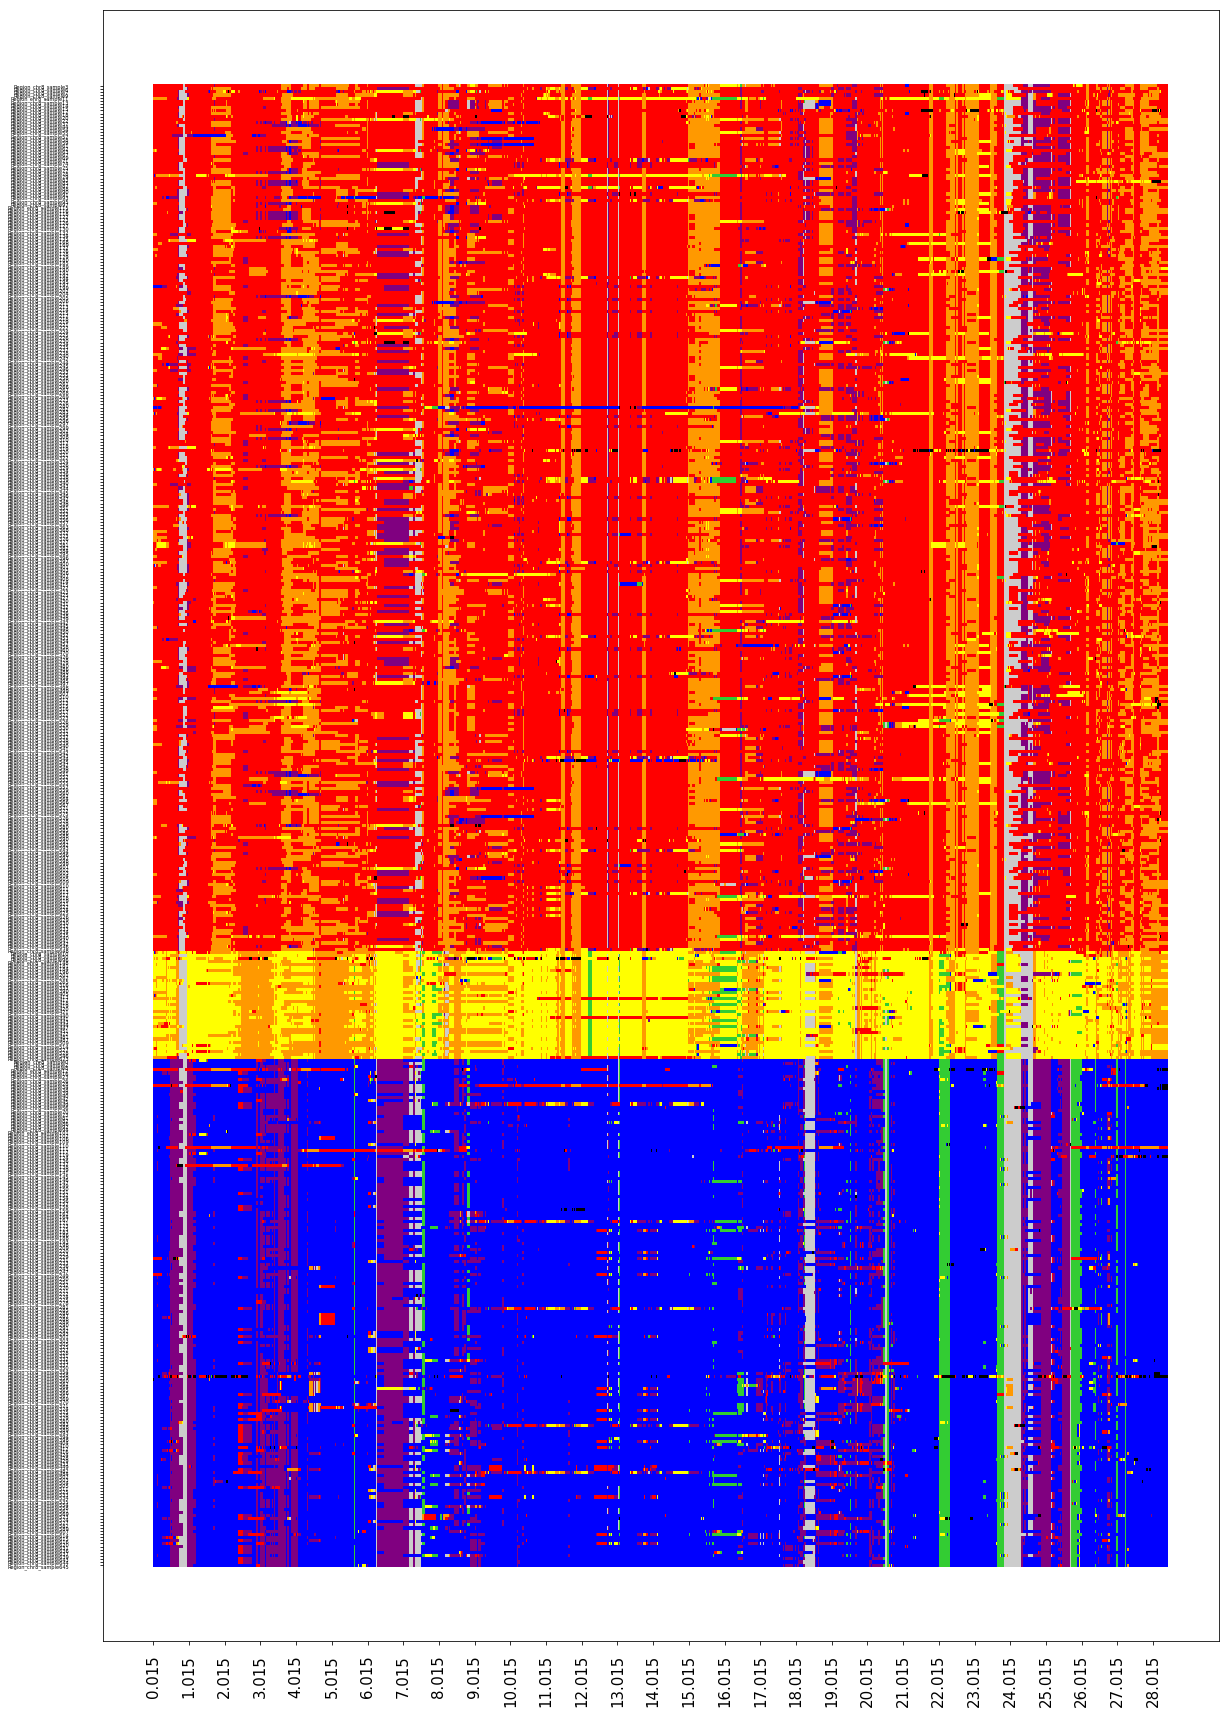

In [15]:

ID= 'kde_gp{}_w{}_N{}_M{}_th{}'.format('-'.join([str(x) for x in groups_plot]),Sn,Sm,window_size,Comparison_threshold)  

Fig_ideo= return_ideogram(ideo_kde,chromosome_list,ID,height= 30,width= 20,xticks= 1e6,xfont= 15)


### F. Curation

This is the curation step. Begin by studying the ideogram of supervised classifications above. Under the KDE approach, the proportion of intermediate classification at each locus is proportional to the degree of overlap of two or more distributions. More importantly, individual intermediate classifications indicate proximity to the region of overlap. 

#### *i. Target mean shift clusters using supervised classification.*

We will now use these classifications to capture these shared structures. We will then force their classification to according to our judgement. This is not always a good idea. Our decision should be based on the distribution of these classifications we can observe above. In some cases a pattern of introgression from one source to another is clear. In these cases we can take the decision to classify the underlying clusters according to what we believe their true origin to be. If this sort of inference proves more complicated, then it is best to await more information to accompany a final decision.

All steps should be recorded and, if presented, the reasoning behind them explained. 

Select target classes to use in `target_class`. Use the index of the colors of choice in the vector `color_groups` (section A).

Select the range along which to query using `start` and `end`, in base pairs.

The `decisions` dictionary will hold successive re-classification decisions as they are made. Run it once and after only to refresh all decisions.

**Targeting**

Within the range provided, every windows will be checked for the labels provided. If they are present, then mean shift and target supervised labels are compared. An accuracy measure is estimated for each cluster identified at that window using mean shift. Accuracy measures are stored in the column 'Acc' of the data frame `Coordinates`. 

In [16]:
decisions= {}

In [86]:
from structure_tools.mstutorial_tools import MAC_predict

target_class= [7]

start= 16.2e6
end= 18e6

Coordinates = MAC_predict(Construct,
                                Blocks,
                                 Out,
                                  blocks_gp= groups_plot,
                                  label_vector= ref_vector,
                                 target_class= target_class,
                                start= start,
                                end= end)

Coordinates.head()

0
4866


,chrom,start,end,bl,members,class_7
0,8,15207,241678,0,0.2.8.16.19.23.25.26.28.38.39.40.42.45.49.56.5...,0.0
1,8,15207,241678,1,1.5.6.7.9.15.18.21.22.27.29.32.37.41.43.44.47....,0.0
2,8,15207,241678,2,3.13.14.24.30.31.35.46.51.58.83.90.127.169.172...,0.0
3,8,15207,241678,3,4.11.63.66.72.79.88.96.97.100.131.134.176.177....,0.0
4,8,15207,241678,4,12.34.48.52.59.62.65.67.76.77.85.87.95.98.99.1...,0.0


#### *ii. Plot captured haplotypes*

Use the `label_threshold` on the accuracy value of each cluster to select which to plot.

0.42028985507246375
4
238
adding ideograms...


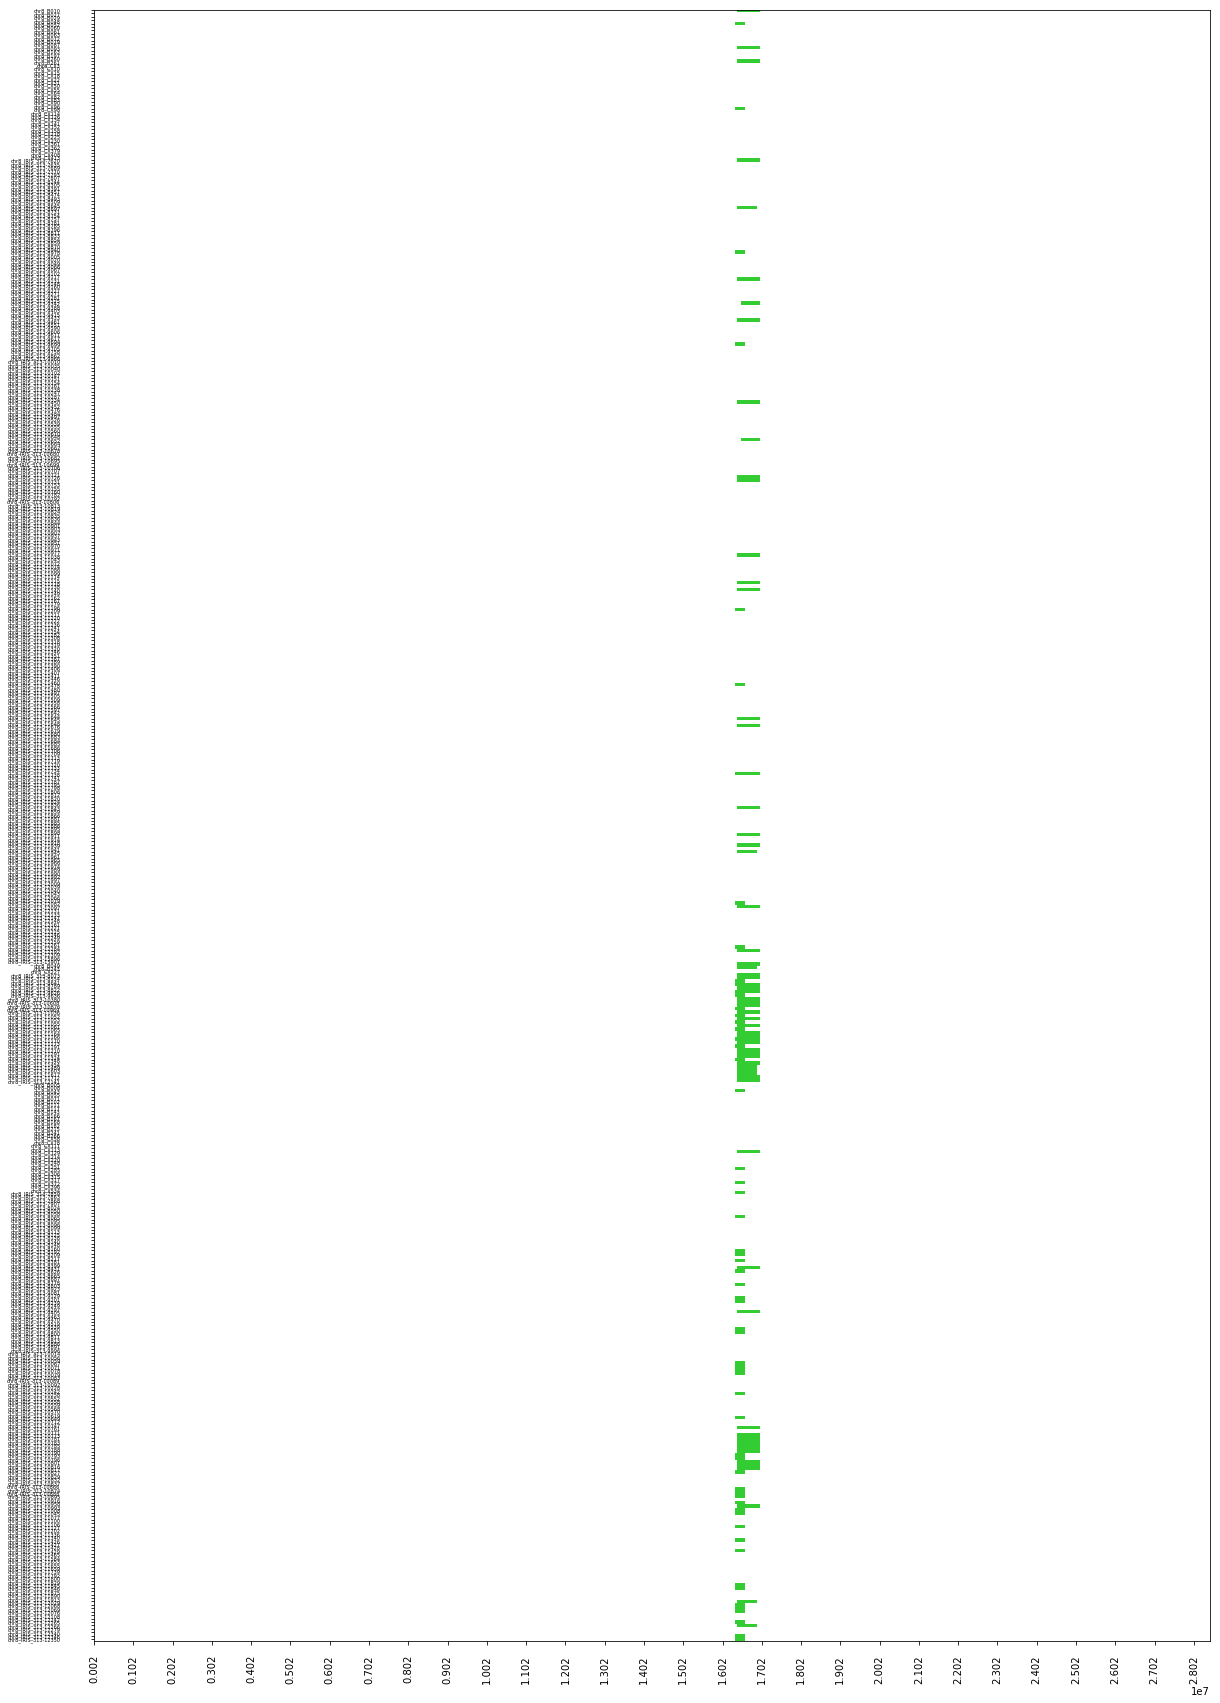

In [88]:
from structure_tools.targeted_tools import mpl_target_ideo, chromosome_collections

select_label= target_class

label_threshold= .3

cluster_labels= [0]*Coordinates.shape[0]

for targ in target_class:
    lab= 'class_' + str(targ)
    print(max(Coordinates[lab]))
    acc= [x for x in range(Coordinates.shape[0]) if float(Coordinates[lab][x]) >= label_threshold]
    print(len(acc))
    for x in acc: 
        cluster_labels[x] = targ

Coordinates['label']= cluster_labels

Chr= 8
plot_tool= 'mpl'

plot_who= groups_plot

order= list(it.chain(*[ref_dict[x] for x in plot_who]))
#order= list(range(len(Nsample)))
names_sample= [Names[x] for x in Nsample]
#names_sample= [names_sample[x] for x in order]

Colors= {
    -1: [192,192,192],
    1: [139,0,0],
    3: [205,0,0],
    4: [255,255,0],
    5: [255,165,0],
    6: [138,43,226],
    7: [50,205,50],
    8: [169,169,169],
    9: [255,0,0],
    2: [0,0,0]
}


if plot_tool== 'plotly':

    Colors= {
        x: 'rgba(' + ','.join([str(z) for z in Colors[x]]) + ',1)' for x in Colors.keys()
    }

    target_ideogram(select_label,Coordinates,IDs,Colors=Colors,Chr= Chr,background= False,height_chrom= .5,height= 10,width= 5)



if plot_tool== 'mpl':
    
    background= True
    ideo_height= 1
    ideo_spacing= 0
    height= 30
    width= 20
    
    xticks= 1e6
    fig_save= True
    fig_id= 'ideo_target_gp{}'.format('.'.join([str(x) for x in plot_who]))
    Home= ''

    mpl_target_ideo(select_label,
                    Coordinates,
                    names_sample,
                    order= order,
                    background= False,
                    Chr= Chr,
                    ideo_height= ideo_height,
                    ideo_spacing= ideo_spacing,
                    xticks= xticks,
                    fig_save= fig_save,
                    fig_id= 'ideo_target',
                    Colors= Colors,
                    height= height,
                    width= width,
                    Home= Home)



#### iii. Decide what to change

This step is important. Mostly because the current move gets stored in `decisions` and to correct it will require manual manipulation.

After analysing the ideogram of targeted haplotypes above, define the swhich requested for each label provided. 

In [89]:
class_moves= {
    'moves': {
        5:1
    },
    'labs':Coordinates['label']
}

decisions[len(decisions)]= class_moves

In [90]:
from structure_tools.targeted_tools_III import renew_ideo

New_blocks, ideo_amend, chromosome_list= renew_ideo(Blocks,Coordinates,decisions,Out,ref_vector,groups_plot=groups_plot,colors= 'standard',
                  alt_col= [])

13 steps provided.
step 0, 2 moves: (6 -> 2),(8 -> 2)
6
8
step 1, 2 moves: (6 -> 2),(8 -> 2)
6
8
step 2, 1 moves: (5 -> 0)
5
step 3, 1 moves: (5 -> 1)
5
step 4, 1 moves: (5 -> 1)
5
step 5, 1 moves: (5 -> 0)
5
step 6, 2 moves: (6 -> 2),(8 -> 2)
6
8
step 7, 2 moves: (7 -> 2),(8 -> 2)
7
8
step 8, 3 moves: (6 -> 2),(7 -> 2),(8 -> 2)
6
7
8
step 9, 1 moves: (5 -> 0)
5
step 10, 2 moves: (5 -> 0),(7 -> 1)
5
7
step 11, 1 moves: (7 -> 2)
7
step 12, 1 moves: (5 -> 1)
5


adding ideograms...


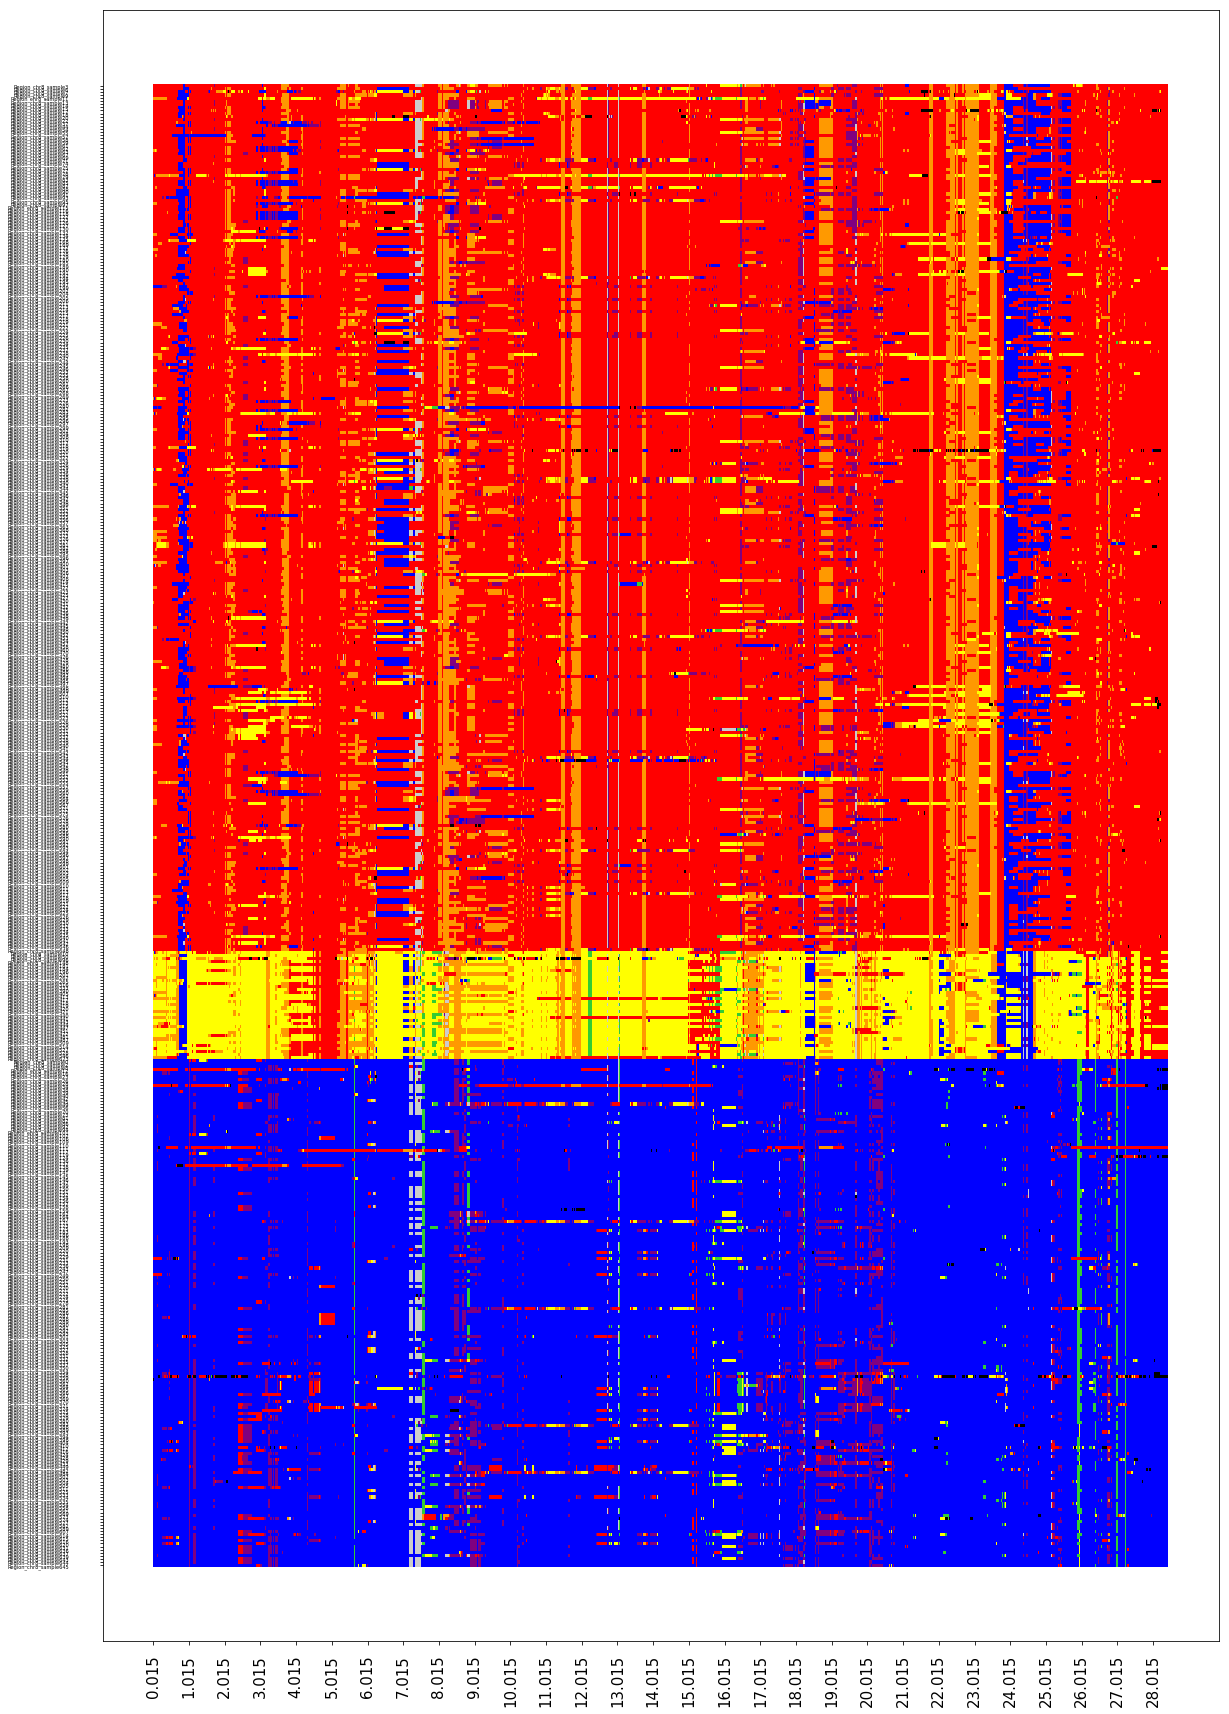

In [91]:

ID= 'amended_kde_gp{}_w{}_N{}_M{}_th{}'.format('-'.join([str(x) for x in groups_plot]),Sn,Sm,window_size,Comparison_threshold)  

Fig_ideo= return_ideogram(ideo_amend,chromosome_list,ID,height= 30,width= 20,xticks= 1e6,xfont= 15)